In [1]:
# %matplotlib inline
# %matplotlib notebook
from dataGen import Gen
from multiscale_vae import vae
from train import slidingWindow, criterion, train, test

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.distributions


import numpy as np
import matplotlib.pyplot as plt

In [24]:
# all parameters for generating the time series should be configured in this cell
time = 1200
step = 0.2
val = 100
n_channels = 3
effects = {
    "Pulse": {
        "number":0,
        "max_gain":5        
        },
    "Trend": {
        "number":2,
        "max_slope":0.1
        },
    "Seasonality": {
        "number":3,
        "frequency_range":(20, 30),
        "amplitude_range":(5, 15),
        }
    }

### Init Model
latent_dims = 16
L = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'

v = vae(n_channels, L, latent_dims)
opt = optim.Adam(v.parameters(), lr = 0.001)

{'T': 6000, 'nchannels': 3, 'mu': array([95, 69, 13]), 'cov': array([[0.31622309, 0.        , 0.        ],
       [0.        , 0.46350788, 0.        ],
       [0.        , 0.        , 0.7612954 ]])}
{'Pulse': {'channel': [], 'index': [], 'scale': []}, 'Trend': {'channel': [2, 0], 'index': [32, 1063], 'slope': [-0.05237801940911613, 0.00933427641145168]}, 'Seasonality': {'channel': [2, 2, 2], 'frequency': [23.821300049605263, 22.530416999421796, 29.076398438415183], 'amplitude': [9, 10, 11], 'phaseshift': [112, 148, 113]}}


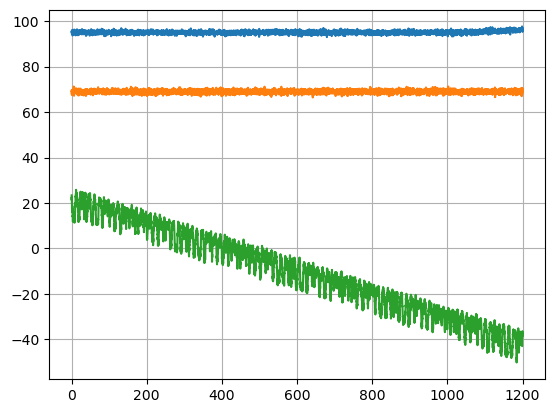

In [30]:
X = Gen(time, step, val, n_channels, effects)
x, params, e_params = X.parameters()
print(params)
print(e_params)
X.show()

In [31]:
# serie = torch.tensor(serie).float()
x = torch.FloatTensor(x)
n = x.shape[1]

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

# train_set = slidingWindow(train, 30)
# val_set = slidingWindow(val, 30)
# test_set = slidingWindow(test, 30)

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size=10,
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=10,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=10,
                        shuffle = False
                        )

In [33]:
for epoch in range(1, 10):
    train(v, train_data, criterion, opt, device, epoch)

Train Epoch: 1 [0/4770 (0%)]	Loss: 2331.248828
Train Epoch: 1 [1000/4770 (21%)]	Loss: 61.055804
Train Epoch: 1 [2000/4770 (42%)]	Loss: 53.413104
Train Epoch: 1 [3000/4770 (63%)]	Loss: 18.801996
Train Epoch: 1 [4000/4770 (84%)]	Loss: 4.310743
====> Epoch: 1 Average loss: 59.2280
Train Epoch: 2 [0/4770 (0%)]	Loss: 2317.911914
Train Epoch: 2 [1000/4770 (21%)]	Loss: 64.381982
Train Epoch: 2 [2000/4770 (42%)]	Loss: 45.825430
Train Epoch: 2 [3000/4770 (63%)]	Loss: 15.047145
Train Epoch: 2 [4000/4770 (84%)]	Loss: 15.210829
====> Epoch: 2 Average loss: 55.7992
Train Epoch: 3 [0/4770 (0%)]	Loss: 2155.786914
Train Epoch: 3 [1000/4770 (21%)]	Loss: 60.587921
Train Epoch: 3 [2000/4770 (42%)]	Loss: 45.995975
Train Epoch: 3 [3000/4770 (63%)]	Loss: 6.439303
Train Epoch: 3 [4000/4770 (84%)]	Loss: 8.776150
====> Epoch: 3 Average loss: 54.4554
Train Epoch: 4 [0/4770 (0%)]	Loss: 2189.136133
Train Epoch: 4 [1000/4770 (21%)]	Loss: 51.655756
Train Epoch: 4 [2000/4770 (42%)]	Loss: 67.854584
Train Epoch: 4 [30

In [50]:
def compare(dataset, model):
    model.eval()
    rec = []
    x = []
    with torch.no_grad():
        for i, data in enumerate(dataset):
            x_rec, mu, logvar = model(data)

            x.extend(data[:,:,0].detach().numpy())
            rec.extend(x_rec[:].detach().numpy())
        
    print(mu[-1, :], logvar[-1, :])
    plt.plot(rec, "r--")
    plt.plot(x[:-L], "b-")
    plt.grid(True)
    
    return mu[-1, :], logvar[-1, :]
    
    
    


tensor([-1.2587,  0.0819,  0.2037,  0.1768,  0.2776, -0.2263,  0.7207, -0.2859,
         0.2831,  0.6206,  0.1357, -0.5361, -0.3691, -0.0790,  0.2580,  0.5034,
        -0.0946,  0.0146,  0.2000, -0.1370,  0.1781, -0.1658, -0.0231,  0.0216,
         0.0311, -0.2453,  0.0027,  0.0990, -0.0774,  0.1473, -0.0707, -0.0471]) tensor([-1.9524, -0.2854, -0.0465, -0.1564, -0.3016, -0.2654, -0.2237, -0.3691,
        -0.1155, -0.1283, -0.1951, -0.5926, -0.2222, -0.1311, -0.1686, -0.0309,
        -0.0837, -0.1373, -0.1434, -0.1005, -0.0797, -0.1431, -0.0625, -0.1115,
        -0.1370, -0.1176, -0.0577, -0.1531, -0.1427, -0.1241, -0.1705, -0.0690])


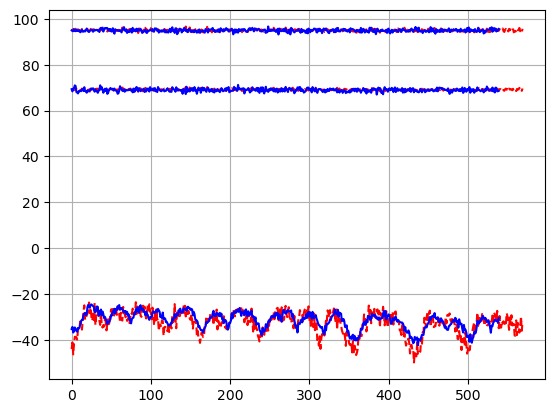

In [91]:
mu, logvar = compare(val_data, v)

In [40]:
test(v, test_data, criterion, device)

====> Test set loss: 55.6809


tensor([-1.2587,  0.0819,  0.2037,  0.1768,  0.2776, -0.2263,  0.7207, -0.2859,
         0.2831,  0.6206,  0.1357, -0.5361, -0.3691, -0.0790,  0.2580,  0.5034,
        -0.0946,  0.0146,  0.2000, -0.1370,  0.1781, -0.1658, -0.0231,  0.0216,
         0.0311, -0.2453,  0.0027,  0.0990, -0.0774,  0.1473, -0.0707, -0.0471]) tensor([-1.9524, -0.2854, -0.0465, -0.1564, -0.3016, -0.2654, -0.2237, -0.3691,
        -0.1155, -0.1283, -0.1951, -0.5926, -0.2222, -0.1311, -0.1686, -0.0309,
        -0.0837, -0.1373, -0.1434, -0.1005, -0.0797, -0.1431, -0.0625, -0.1115,
        -0.1370, -0.1176, -0.0577, -0.1531, -0.1427, -0.1241, -0.1705, -0.0690])


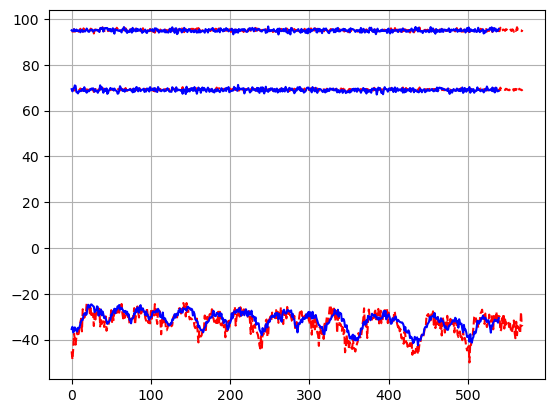

In [103]:
mu, logvar = compare(val_data, v)

1000


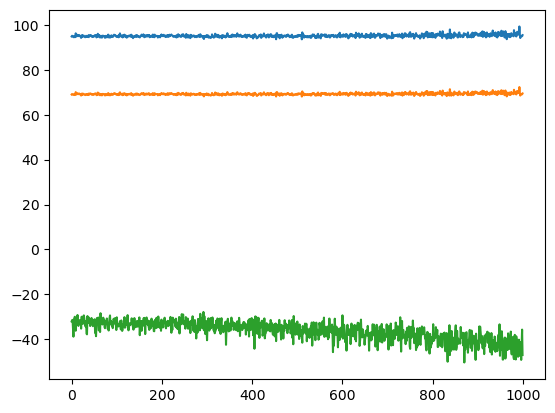

In [104]:
rec = []
for i in range(1000):
    mu[16] = 0.01*i
    z = v.reparametrization_trick(mu, logvar)
    
    x_rec = v.decoder(z)
#     print(x_rec.shape)
    rec.append(x_rec.detach().numpy())
print(len(rec))
plt.plot(rec)